# Developing a toy model for exploring uncertainties in the Pearson correlation coefficient

We want a model framework that produces "climate-like" signals with the following properties:
- ability to dial up/down the serial correlation
- ability to dial up/down the number of ensemble members to produce realistic smoothing
- explore the effect of trends

In [1]:
import numpy as np

import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import Divider, Size

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

import cartopy
import cartopy.crs as ccrs

/datasets/work/oa-dcfp/work/squ027/.conda/envs/forecast_analysis/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
DATA_DIR = "../../data/"

cartopy.config["pre_existing_data_dir"] = f"{DATA_DIR}/cartopy-data"
cartopy.config["data_dir"] = f"{DATA_DIR}/cartopy-data"

## Load some example real signals to explore and replicate

In [4]:
can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.precip_global.zarr"
)
can["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.t_ref_global.zarr"
)["t_ref"]
can["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.sst_global.zarr"
)["sst"]

ec = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.precip_global.zarr"
)
ec["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.t_ref_global.zarr"
)["t_ref"]
ec["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.sst_global.zarr"
)["sst"]
ec["slp"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.slp_global.zarr"
)["slp"]

## What do the partial autocorrelation functions look like for these fields?

In [5]:
def acf(ds, dim="time", partial=False, nlags=10):
    """Vectorized Autocorrelation Function for xarray objects"""
    import statsmodels.api as sm

    def _acf(data, nlags, partial):
        if partial:
            return sm.tsa.pacf(data, nlags=nlags)
        else:
            return sm.tsa.acf(data, nlags=nlags)

    return xr.apply_ufunc(
        _acf,
        ds,
        kwargs=dict(nlags=nlags, partial=partial),
        input_core_dims=[[dim]],
        output_core_dims=[["lag"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={"lag": nlags + 1}),
    ).assign_coords({"lag": range(nlags + 1)})

In [6]:
pacf_can = acf(can, partial=True)
pacf_ec = acf(ec, partial=True)

In [92]:
def plot_pacf_lags(pacf, lags, title=None, figsize=None, vrange=(-1, 1)):

    nrows = len(pacf)
    ncols = len(lags)
    if figsize is None:
        figsize = (5.0 * ncols, 2.5 * nrows)

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        nrows,
        ncols,
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.PlateCarree(180)),
    )

    bounds = np.linspace(vrange[0], vrange[1], 21)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)

    for y, l in enumerate(lags):
        for x, v in enumerate(pacf.keys()):
            ax = axs[x, y]
            p = (
                pacf[v]
                .sel(lag=l)
                .plot(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    vmin=vrange[0],
                    vmax=vrange[1],
                    norm=norm,
                    cmap="RdBu_r",
                    add_colorbar=False,
                )
            )
            p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

            ax.set_title(f"{v} | lag {l}")

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(0), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal")

    if title:
        fig.suptitle(title)

    return fig

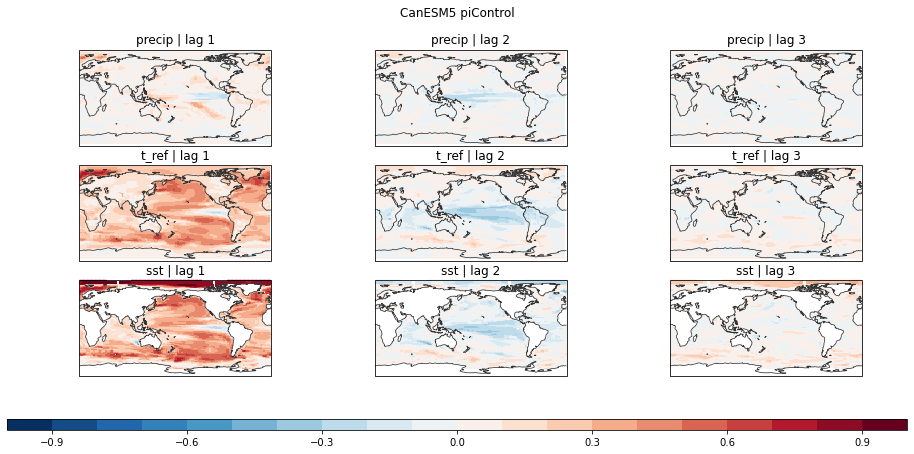

In [49]:
_ = plot_pacf_lags(pacf_can, lags=[1, 2, 3], title="CanESM5 piControl")

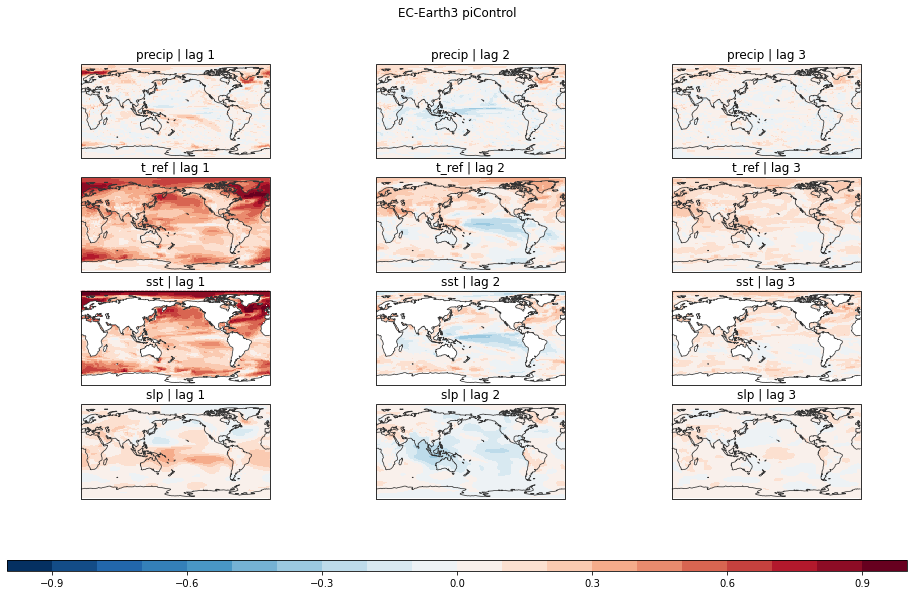

In [50]:
_ = plot_pacf_lags(pacf_ec, lags=[1, 2, 3], title="EC-Earth3 piControl")

## Determine AR(2) coefficients from Yule-Walker equations

In [226]:
def yule_walker(ds, order, dim="time"):
    """Vectorized Autocorrelation Function for xarray objects"""
    from statsmodels.regression.linear_model import yule_walker

    def _yule_walker(data, order):
        rho, sigma = yule_walker(data, order=order, demean=True)
        return np.array((sigma, *rho))

    return xr.apply_ufunc(
        _yule_walker,
        ds,
        kwargs=dict(order=order),
        input_core_dims=[[dim]],
        output_core_dims=[["coeff"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={"coeff": order + 1}),
    ).assign_coords({"coeff": range(order + 1)})

## Plot $\phi_1$ vs $\phi_2$

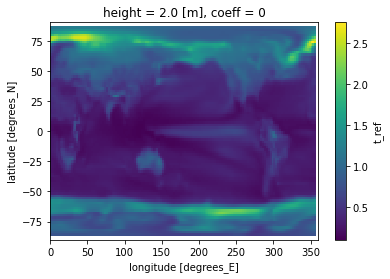

In [256]:
coeffs["t_ref"].sel(coeff=0).plot()

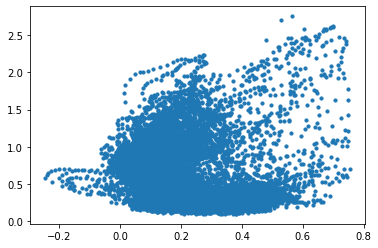

In [259]:
coeffs = yule_walker(can, order=1).compute()

plt.scatter(
    coeffs["t_ref"].sel(coeff=1),
    coeffs["t_ref"].sel(coeff=0),
    s=10,
    #     c=coeffs["t_ref"].sel(coeff=0),
)
# plt.xlim(-1, 1.1)
# plt.ylim(-0.5, 0.5)

## What about coming up with e.g. three example cases with similar ACFs, for example to:
- highly correlated sst index
- nao index
- "independent" precip index

In [78]:
from statsmodels.tsa.ar_model import AutoReg

In [149]:
test = can["sst"].sel(lat=60, lon=180, method="nearest").compute().values

In [203]:
f = AutoReg(test, lags=2, trend="n").fit()

In [204]:
f.params

array([0.54150323, 0.01317337])

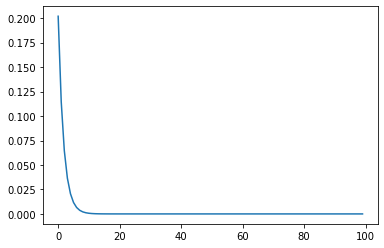

In [205]:
plt.plot(f.forecast(100))

In [206]:
from statsmodels.regression.linear_model import yule_walker

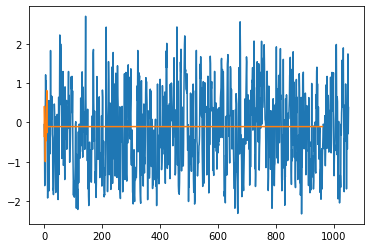

In [181]:
plt.plot(test)

plt.plot(f.predict(start=1040, end=2000, dynamic=1050))

In [ ]:
def AutoReg(ds, dim="time", partial=False, nlags=10):
    """Vectorized Autocorrelation Function for xarray objects"""
    import statsmodels.api as sm

    def _acf(data, nlags, partial):
        if partial:
            return sm.tsa.pacf(data, nlags=nlags)
        else:
            return sm.tsa.acf(data, nlags=nlags)

    return xr.apply_ufunc(
        _acf,
        ds,
        kwargs=dict(nlags=nlags, partial=partial),
        input_core_dims=[[dim]],
        output_core_dims=[["lag"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={"lag": nlags + 1}),
    ).assign_coords({"lag": range(nlags + 1)})

In [73]:
def init(size):
    
    return arma_process.generate_sample(nsample=size[0])

In [74]:
nsamples = 100
ntimes = 50

ar = np.array([1, -0.8])

arma_process = ArmaProcess(ar)
s = arma_process.generate_sample(nsample=(nsamples, 2), distrvs=init, axis=0)

In [77]:
s.shape

(100,)

In [68]:
s.plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [54]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [55]:
import statsmodels.tsa.ar_model

In [ ]:
AutoReg()

In [52]:
np.std(s)

1.2884386827350243

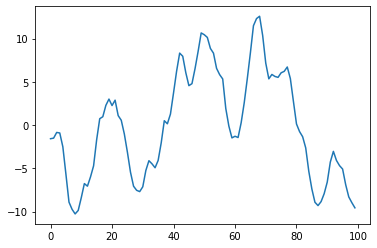

In [75]:
plt.plot(s)

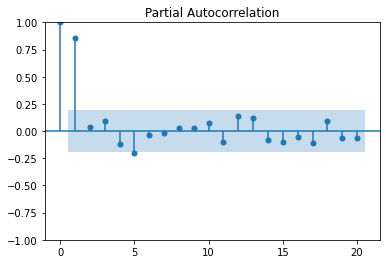

In [45]:
_ = plot_pacf(s, method="ywm")